In [1]:
import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

My first try at fitting

In [2]:
# Independent variables
redshifts = np.array([3, 3.8, 4, 4.9, 5, 5.9, 6, 6.9, 7, 7.9, 8])
MUV = np.arange(-28, -8.8, 0.2)
# Mh = np.logspace(7, 13, 61)

# blob 1: the LF. Give it a name, and the function needed to calculate it.
blob_n1 = ['galaxy_lf']
blob_i1 = [('z', redshifts), ('x', MUV)]
blob_f1 = ['LuminosityFunction']

In [3]:
blob_pars = \
{
 'blob_names': [blob_n1],
 'blob_ivars': [blob_i1],
 'blob_funcs': [blob_f1],
 'blob_kwargs': [None],
}

In [4]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)
# base_pars.update({'progress_bar': True, 'debug':True}) #this doesn't seem to do anything

# This is important!
base_pars['pop_calib_lum'] = None

In [5]:
free_pars = \
  [
   'pq_func_par0[4]', #this is the constant
   'pq_func_par1[4]', #offset
   'pq_func_par2[4]', #slope
  ]

is_log = [False]#, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(1e-8, 5e-1), 'pq_func_par0[4]')
ps.add_distribution(UniformDistribution(0, 5e-1),  'pq_func_par1[4]')
ps.add_distribution(UniformDistribution(0, 5e-1),   'pq_func_par2[4]')

In [6]:
guesses = \
{
 'pq_func_par0[4]': 3e-4,
 'pq_func_par1[4]': 0,
 'pq_func_par2[4]': 0,
}

In [198]:
# Initialize a fitter object and give it the data to be fit
fitter_lf = ares.inference.FitGalaxyPopulation(**base_pars)

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
# fitter_lf.redshifts = {‘lf’: [5.9]}
fitter_lf.data = 'bouwens2015', 'bouwens2017'

# print(fitter_lf.data)

In [199]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_lf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [ ]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
# 2-D blobs can get large, so this allows us to just download a single
# snapshot or two if we'd like (useful if running on remote machine)
fitter.checkpoint_append = False

fitter.parameters = free_pars
# fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 100

fitter.jitter = [0.001] * len(fitter.parameters)
fitter.guesses = guesses
# fitter.pops

In [ ]:
# Run the thing
fitter.run('test_lfcal', burn=10, steps=70, save_freq=1, clobber=True)

In [6]:
anl = ares.analysis.ModelSet('test_lfcal')


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ./                                                                                     ####
#### prefix      : test_lfcal                                                                             ####
#### N-d         : 3                                                                                      ####


# Loading test_lfcal.dd*.chain.pkl...
# Loaded test_lfcal.dd*.chain.pkl in 0.065 s.
# Loaded test_lfcal.dd0000.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0001.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0002.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0003.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0004.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0005.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0006.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0007.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0008.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0009.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0010.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0011.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0012.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0013.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0014.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0015.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0016.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0017.blob_2d.galaxy_lf.pkl
# Loaded test_lfcal.dd0018.blob_2d

C:\Users\Emma\Anaconda3\lib\site-packages\numpy\ma\core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
C:\Users\Emma\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


# WARNING: finkelstein2015 wavelength=1500.0A, not 1600A!


C:\Users\Emma\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


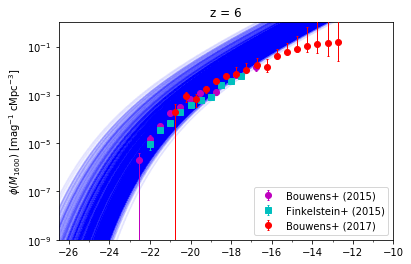

In [7]:
gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotLF(6, ax=ax, round_z=0.2)
ax.set_title("z = 6")

ax.set_ylim(1e-9, 1)
ax.legend()
pl.show()

In [8]:
labels = {
    'pq_func_par0[4]':'const', #this is the constant
   'pq_func_par1[4]': 'offset',
   'pq_func_par2[4]': 'slope'
}

anl.custom_labels = labels

anl.custom_labels

{'pq_func_par0[4]': 'const',
 'pq_func_par1[4]': 'offset',
 'pq_func_par2[4]': 'slope'}

0 of 7000 chain elements ignored because of chain links with inf's/nan's.


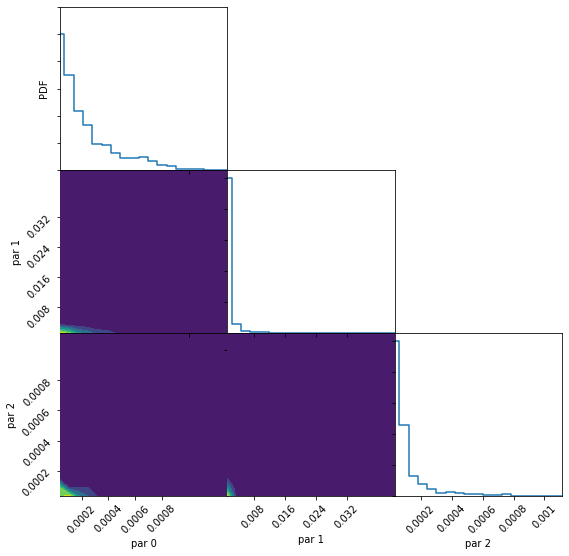

In [9]:
z = 6
# free_pars

ax = anl.TrianglePlot(pars=free_pars, ivar=[z, None, None])
# anl.set_axis_labels(pars=free_pars, ax=ax)
# anl.TrianglePlot(pars='pq_func_par0[4]', ivar=z)

#, label_panels=free_pars)

# (pars=params, ivar=[z, None, None, None, None, None, None, None], \
#                  label_panels=params

this:
[-3.20847073e+06 -3.20847073e+06 -3.20847073e+06 -2.61282937e+06
 -2.61282937e+06 -1.61320176e+06 -1.61320176e+06 -1.61320176e+06
 -1.61320176e+06 -1.61320176e+06 -1.61320176e+06 -1.61320176e+06
 -1.61320176e+06 -9.83771534e+05 -9.83771534e+05 -8.95366011e+05
 -8.95366011e+05 -6.31345929e+05 -2.02585162e+05 -3.95091637e+04
 -3.95091637e+04 -3.95091637e+04 -3.95091637e+04 -3.95091637e+04
 -3.95091637e+04 -2.42573167e+04 -2.42573167e+04 -2.42573167e+04
 -2.42573167e+04 -1.16541751e+04 -1.16541751e+04 -1.16541751e+04
 -9.25862697e+03 -4.54504815e+03 -4.54504815e+03 -4.54504815e+03
 -3.95820408e+03 -2.63735253e+03 -2.63534891e+03 -2.63534891e+03
 -7.93799611e+02 -7.19716955e+02 -5.00970290e+01 -5.00970290e+01
 -5.00970290e+01 -5.00970290e+01  4.71394163e+01  6.08152616e+01
  1.29156805e+02  1.29156805e+02  1.41298195e+02  1.41298195e+02
  1.41298195e+02  1.41298195e+02  1.46998689e+02  1.46998689e+02
  1.62178352e+02  1.62178352e+02  1.62178352e+02  1.62178352e+02
  1.62178352e+02  1

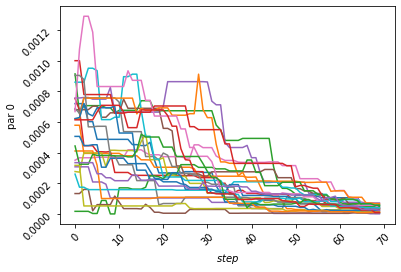

In [10]:
anl.WalkerTrajectories('pq_func_par0[4]', N=25)

['pq_func_par0[4]', 'pq_func_par1[4]', 'pq_func_par2[4]']


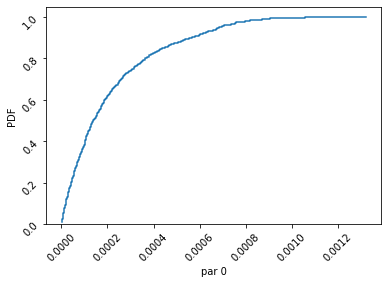

In [14]:
print(free_pars)

# p = anl.PosteriorPDF(free_pars)
# print(p)

anl.PosteriorCDF('pq_func_par0[4]')


In [15]:
covar = anl.CovarianceMatrix(free_pars)

if len(covar[0]) == 1:
    print("{}: {}".format(free_pars[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(free_pars[i], covar[0][i]))

pq_func_par0[4]: 2.178209e-04
pq_func_par1[4]: 1.277313e-03
pq_func_par2[4]: 1.062072e-04


In [16]:
anl.max_likelihood_parameters()

{'pq_func_par0[4]': 1.2543985876791505e-07,
 'pq_func_par1[4]': 0.0024988000380182364,
 'pq_func_par2[4]': 6.631729787578066e-05}